# Fine-tuning a LLM

This notebook illustrates how to finetune a LLM for document classification. We will make use of a bidirectional transformer pre-trained as a masked-language model (MLM), BERT-style, and insert that into an architecture for document classification, adding a feed-forward layer (aka classification head) on top of the embedding of the [CLS] token.

In [60]:
import csv
import copy

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE

from matplotlib import pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader

from transformers import AutoModel, AutoTokenizer

## Load a BERT-like model

We'll choose a small (distilled) model to make things fast and easy but any bidirectional (or even causal) model can be used here. We'll go for https://huggingface.co/distilbert/distilbert-base-uncased but you might want to try other options such as https://huggingface.co/distilbert/distilroberta-base. 

Note that these models were pre-trained as masked language models on English data and are therefore only suited for English texts. If you are to process French texts, typical models are CamemBERT and FlauBERT, some of them having distilled (smaller) versions. 

We will simply load the encoder (AutoModel), without the language model classification (AutoModelForMaskedLM) that we used in the previous notebook. Hence, the output has no logits but only embeddings.

We also briefly illustrate how to tokenize a list of texts at once, also taking care of padding and truncation (the tokenizer does that for you in a pretty efficient and nice manner, so let's simply make use of this feature). See https://huggingface.co/docs/transformers/main/en/model_doc/distilbert for details on the output of the model.

In [3]:
#
# Load tokenizer and model
#

checkpoint = 'distilbert-base-uncased' # distilroberta-base

tokenizer = AutoTokenizer.from_pretrained(checkpoint) # load tokenizer
bert = AutoModel.from_pretrained(checkpoint) # load model
bert.eval()

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

In [4]:
#
# This is a reminder of how the model can be used. Contrary to the previous notebook, we illustrate
# how multiple texts can be passed on to the tokenizer and the model. Note that the former directly 
# takes care of padding and truncation.
#

texts = ['I enjoy playing with LLMs.', 'Finetuning is fun!']

inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
print('Output of tokenizer:\n', inputs)
print('Tokens and text:', tokenizer.convert_ids_to_tokens(inputs['input_ids'][0]), '--', tokenizer.decode(inputs['input_ids'][0]))

with torch.no_grad():
    outputs = bert(**inputs)

print('Output shape:', outputs.last_hidden_state.shape)

Output of tokenizer:
 {'input_ids': tensor([[ 101, 1045, 5959, 2652, 2007, 2222, 5244, 1012,  102],
        [ 101, 2986, 8525, 5582, 2003, 4569,  999,  102,    0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0]])}
Tokens and text: ['[CLS]', 'i', 'enjoy', 'playing', 'with', 'll', '##ms', '.', '[SEP]'] -- [CLS] i enjoy playing with llms. [SEP]
Output shape: torch.Size([2, 9, 768])


## Get data for document classification

We will use the same SST2 dataset as we already used for document classification. 

### Read the data and split into train/valid/test folds

In [5]:
def clean_and_tokenize_utterance(x: dict) -> dict:
    '''
    Tokenize utterance with basic rules and convert labels to int. Input an entry of the dataset as
    a dict() and returns the dictionary augmented with the list of tokens (as strings). Also converts
    the label to an integer.
    '''
    unwanted =  ("``", "''", "'", "`", "--", ",", ".")
    
    x['tokens'] = [token for token in x['sentence'].split() if token not in unwanted]
    x['label'] = int(x['label'])
    
    return x

In [7]:
#
# Let's first load raw data from the CSV files. 
#

fn = './SST-2/train.tsv'

with open(fn, 'r') as f:
    data = [x for x in csv.DictReader(f, delimiter="\t")] 

data = list(map(clean_and_tokenize_utterance, data))

for i in range(10):
    print('sample {} -- class={}, string=/{}/'.format(i, data[i]['label'], data[i]['sentence']))


sample 0 -- class=0, string=/hide new secretions from the parental units /
sample 1 -- class=0, string=/contains no wit , only labored gags /
sample 2 -- class=1, string=/that loves its characters and communicates something rather beautiful about human nature /
sample 3 -- class=0, string=/remains utterly satisfied to remain the same throughout /
sample 4 -- class=0, string=/on the worst revenge-of-the-nerds clichés the filmmakers could dredge up /
sample 5 -- class=0, string=/that 's far too tragic to merit such superficial treatment /
sample 6 -- class=1, string=/demonstrates that the director of such hollywood blockbusters as patriot games can still turn out a small , personal film with an emotional wallop . /
sample 7 -- class=1, string=/of saucy /
sample 8 -- class=0, string=/a depressed fifteen-year-old 's suicidal poetry /
sample 9 -- class=1, string=/are more deeply thought through than in most ` right-thinking ' films /


In [8]:
#
# You can adjust here to get more or less data. Commented lines make use of the whole dataset while
# actual code only takes a small fraction of the data to make training faster.
#

fold = dict()

# fold['train'], buf = train_test_split(data, test_size=0.3, random_state=42)
# fold['valid'], fold['test'] = train_test_split(buf, test_size=0.5, random_state=42)

fold['train'], buf = train_test_split(data, test_size=0.8, random_state=42)
fold['valid'], buf = train_test_split(buf, test_size=0.9, random_state=42)
fold['test'], _ = train_test_split(buf, test_size=0.9, random_state=42)

for s in ('train', 'valid', 'test'):
    buf = fold[s]
    n0 = len([x for x in buf if int(x['label']) == 0])
    n1 = len([x for x in buf if int(x['label']) == 1])

    print('{:6s} = {}  {}/{}'.format(s, len(buf), n0, n1))

for item in fold['train'][:10]:
    print(item)

train  = 13469  6050/7419
valid  = 5388  2337/3051
test   = 4849  2179/2670
{'sentence': "just too bad the film 's story does not live up to its style ", 'label': 0, 'tokens': ['just', 'too', 'bad', 'the', 'film', "'s", 'story', 'does', 'not', 'live', 'up', 'to', 'its', 'style']}
{'sentence': "secretary is a genial romance that maintains a surprisingly buoyant tone throughout , notwithstanding some of the writers ' sporadic dips into pop freudianism . ", 'label': 1, 'tokens': ['secretary', 'is', 'a', 'genial', 'romance', 'that', 'maintains', 'a', 'surprisingly', 'buoyant', 'tone', 'throughout', 'notwithstanding', 'some', 'of', 'the', 'writers', 'sporadic', 'dips', 'into', 'pop', 'freudianism']}
{'sentence': 'quite possibly the sturdiest example yet of why the dv revolution has cheapened the artistry of making a film ', 'label': 0, 'tokens': ['quite', 'possibly', 'the', 'sturdiest', 'example', 'yet', 'of', 'why', 'the', 'dv', 'revolution', 'has', 'cheapened', 'the', 'artistry', 'of', 'm

### Convert data to Dataset

The dataset simply stores the encodings as returned by the tokenizer and the corresponding labels. 

We assume here that input to the tokenizer ia already split into tokens (i.e., input as a list of tokens (as str) rather than a single string to break into tokens -- this is why we have is_split_into_words=True). We also assume that the tokenizer takes care of the padding and truncation.

Note that datasets can be saved if you don't want to run these steps over and over again. Here's how to do that:

```python
import pickle

fn = "pytorch-datasets.pkl"

with open(fn, "wb") as f:
    pickle.dump(ds, f)

with open(fn, "rb") as f: 
    ds = pickle.load(f)
```

In [9]:
#
# Dataset class definition and convertion function from pre-processed data to torch Dataset
#

class SST2Dataset(Dataset):
    def __init__(self, _data, _tokenizer):
        self.encodings = _tokenizer([x['tokens'] for x in _data])
        self.labels = [x['label'] for x in _data]
        self.nlabels = len(set(self.labels))

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['label'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    

tok_fn =  lambda x: tokenizer(x, is_split_into_words=True, truncation=True, padding=True)

ds = dict()
ds['train'] = SST2Dataset(fold['train'], tok_fn)
ds['valid'] = SST2Dataset(fold['valid'], tok_fn)
ds['test'] = SST2Dataset(fold['test'], tok_fn)


In [10]:
print(fold['train'][0]['tokens'])
print(ds['train'][0])
print(tokenizer.decode(ds['train'][0]['input_ids']))

['just', 'too', 'bad', 'the', 'film', "'s", 'story', 'does', 'not', 'live', 'up', 'to', 'its', 'style']
{'input_ids': tensor([ 101, 2074, 2205, 2919, 1996, 2143, 1005, 1055, 2466, 2515, 2025, 2444,
        2039, 2000, 2049, 2806,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'label': tensor(0)}
[CLS] just too bad the film ' s story does not live up to its style [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

## Create and train a classification model

We will define a simple model that simply takes the embeddig of the [CLS] token as provided by the BERT-like encoder and run it through a feed-forward layer to predict logits for the output classes. We will thus use a standard cross-entropy loss function, following exactly the same training steps as what we did in the document classification notebook. We will limit ourselves to one or two iterations as training can be somewhat slow with transformers.

We can directly make use of the train_step() and eval_step() functions that we defined previously. Also remember you cna save models to disk with

```python
fn = 'model.pt'
torch.save(model.state_dict(), fn)
model.load_state_dict(torch.load(fn, weights_only=True))
```

**Important:** Transormers are known to require a smaller learning rate than basic of recurrent neural networks. We wil thus lower the learning rate to 1e-5 (as opposed to 1e-4 or 5e-4 typically used with standard networks).

In [11]:
#
# Define the model to do the following:
#    1. encode input with the BERT encoder
#    2. get embedding of token [CLS] (dimension is 768, i.e.,  encoder.config.dim)
#    3. run classification from the [CLS] embedding through two feed-forward layers
#

class BERTClassifier(torch.nn.Module):

    def __init__(self, _encoder, nclasses = 2, dropout = None):
        super(BERTClassifier, self).__init__()

        self.nclasses = nclasses
        self.encoder = copy.deepcopy(_encoder) # to avoid modifying the encoder directly
        self.dropout = torch.nn.Dropout(dropout) if dropout != None else None
        self.linear1 = torch.nn.Linear(self.encoder.config.dim, 100)
        self.activation = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(100, nclasses)
        # self.softmax = torch.nn.Softmax()

    def forward(self, **kwargs):
        x = self.encoder(**kwargs)        # run batch through the BERT encoder
        x = x.last_hidden_state[:,0,:]    # get embedding of [CLS] token for each input in the batch
        if self.dropout != None:
            x = self.dropout(x)
        x = self.linear1(x)               # project to a 100-d hidden layer
        x = self.activation(x)
        if self.dropout != None:
            x = self.dropout(x)
        x = self.linear2(x)               # project to logits, one per class
        # x = self.softmax(x)
        
        return x

model = BERTClassifier(bert, nclasses = ds['train'].nlabels, dropout = 0.2)


In [13]:
#
# Define the training and evaluation steps
#

def train_step(_model, _loader, _loss, _optim, device="cpu", report=0):
    '''
    Generic training step.

    Assumes loader returns batches where the labels are accessed with the 'label' keyword.
    All other keywords are passed as **kwargs to the model.
    
    If report is set to a number, reports stats on training every 'report' batches.

    :return: total_loss accumulated throughout the epoch
    '''

    _model.train(True)
    total_loss = 0.
    running_loss = 0.

    for i, batch in enumerate(_loader):
        _optim.zero_grad()

        labels = batch['label'].to(device)

        inputs = {k: v.to(device) for k, v in batch.items() if k != 'label'}
        outputs = _model(**inputs)

        loss = _loss(outputs, labels)
        total_loss += loss.item()
        running_loss += loss.item()

        loss.backward()
        _optim.step()

        if report != 0 and i % report == report - 1:
            print('  batch {} avg. loss per batch={:.4f}'.format(i + 1, running_loss / report))
            running_loss = 0.

    _model.train(False)

    return total_loss


def eval_step(_model, _loader, device='cpu', loss_fn=None):
    '''
    Evaluate the model's performance on data within loader.
    
    :return: 
    total_loss accumulated throughout the batches
    accuracy
    '''

    _model.eval()  # disable training mode

    logits = torch.empty((0, _model.nclasses)).to(device)
    labels = torch.empty((0)).to(device)

    total_loss = 0.

    for batch in _loader:
        batch_labels = batch['label'].to(device)
        labels = torch.cat((labels, batch_labels), dim=0)

        inputs = {k: v.to(device) for k, v in batch.items() if k != 'label'}

        with torch.no_grad():
            outputs = _model(**inputs)

        logits = torch.cat((logits, outputs), dim=0)

        if loss_fn != None:
            loss = loss_fn(outputs, batch_labels)
            total_loss += loss.item()


    labels = labels.cpu()
    logits = logits.cpu()

    predictions = torch.argmax(logits, dim=-1)
    
    return total_loss, accuracy_score(labels, predictions)


In [14]:
#
# Set training parameters
#

batch_size = 16
lr = 1e-5
nepochs = 2
report_freq = 100

if torch.backends.mps.is_built(): # MPS GPU library for MacOS -- requires metal to be installed
    device = "mps"
    torch.mps.empty_cache()
elif torch.cuda.is_available(): # CUDA GPU acceleration available
    device = torch.device('cuda')
else:
    device = "cpu"
print(f'Running on {device} device')

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
celoss = torch.nn.CrossEntropyLoss()

Running on cuda device


In [15]:
#
# Batch data for training
#
loader = dict()
loader['train'] = DataLoader(ds['train'], batch_size=batch_size, shuffle=True) # set to False for debugging purposes
loader['valid'] = DataLoader(ds['valid'], batch_size=batch_size)
loader['test'] = DataLoader(ds['test'], batch_size=batch_size)

print('Number of samples:', len(ds['train']))
print(f'Number of training batches:', len(loader['train']))

#
# Run the training loop
#
model.to(device)

for epoch in range(nepochs):
    print(f'epoch: {epoch}')
    
    total_loss = train_step(model, loader['train'], celoss, optimizer, device=device, report=report_freq)
    _, trn_acc = eval_step(model, loader['train'], device=device, loss_fn=None)
    
    val_loss, val_acc = eval_step(model, loader['valid'], device=device, loss_fn=celoss)

    print('  **train** avg_loss={:.4f}    acuracy={:.2f}%'.format(total_loss / len(loader['train']), 100 * trn_acc))
    print('  **valid** avg_loss={:.4f}    acuracy={:.2f}%'.format(val_loss / len(loader['valid']), 100 * val_acc))


Number of samples: 13469
Number of training batches: 842
epoch: 0
  batch 100 avg. loss per batch=0.6217
  batch 200 avg. loss per batch=0.3685
  batch 300 avg. loss per batch=0.3520
  batch 400 avg. loss per batch=0.2878
  batch 500 avg. loss per batch=0.2878
  batch 600 avg. loss per batch=0.2693
  batch 700 avg. loss per batch=0.2807
  batch 800 avg. loss per batch=0.2347
  **train** avg_loss=0.3330    acuracy=93.61%
  **valid** avg_loss=0.2471    acuracy=90.09%
epoch: 1
  batch 100 avg. loss per batch=0.1690
  batch 200 avg. loss per batch=0.1670
  batch 300 avg. loss per batch=0.1827
  batch 400 avg. loss per batch=0.1776
  batch 500 avg. loss per batch=0.1786
  batch 600 avg. loss per batch=0.1881
  batch 700 avg. loss per batch=0.1663
  batch 800 avg. loss per batch=0.1858
  **train** avg_loss=0.1758    acuracy=97.25%
  **valid** avg_loss=0.2304    acuracy=91.17%


In [ ]:
_, tst_acc = eval_step(model, loader['test'], device=device, loss_fn=None)

print('  **test** acuracy={:.2f}%'.format(100 * tst_acc))

## Visualize document embeddings

The BERT encoder acts a document embedder, turning a document into a 768-dimensional representation through the layers of transformer-blocks. We can thus visualize these embeddings with t-SNE, before and after fine-tuning the BERT encoder to figure out what exactly fine-tuning does. 

In [58]:
def get_embeddings(_encoder, _loader, nbatches = 10):
    '''
    Return the document embeddings.
    '''
    
    global batch_size
    
    nsamples = nbatches * batch_size

    embeddings = np.empty((nsamples, bert.config.dim))
    labels = np.empty(nsamples)

    for i, batch in enumerate(_loader):
    
        if i == nbatches: break
        
        with torch.no_grad():
            inputs = {k: v for k, v in batch.items() if k != 'label'}
            outputs = _encoder(**inputs)
        
        for j in range(batch_size):
            embeddings[i*batch_size + j,:] = outputs.last_hidden_state[j,0,:].detach().numpy()
    
    return embeddings

(160, 2)


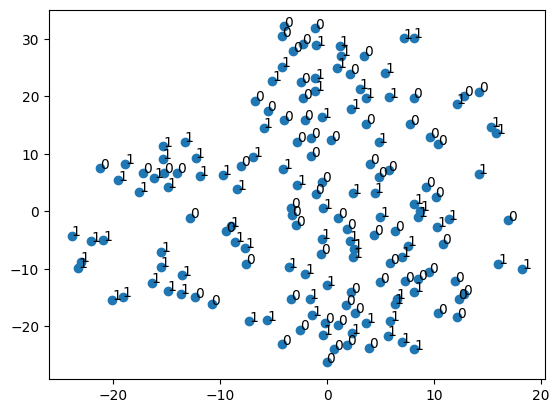

In [46]:
#
# TODO: retrieve document embeddings for test documents using (a) the original BERT encoder (before finetuning)
# and (b) the adapted encoder within the classification model and plot with t-SNE the corresponding document 
# embeddings.  
#
#
# tSNE projection with cosine distance
#

from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

# Adjust the number of batches to match the size of the test dataset
#nbatches = len(loader['test'].dataset) // batch_size
embeddings = get_embeddings(bert, loader['test'], nbatches=10)


Y = TSNE(n_components=2, metric='cosine', init='random', random_state=0, perplexity=10).fit_transform(embeddings)
print(Y.shape)

plt.scatter(Y[:,0], Y[:,1])
for i in range(len(Y)):
    plt.annotate((loader['test'].dataset.labels)[i], xy=(Y[i,0],Y[i,1]))

(160, 2)


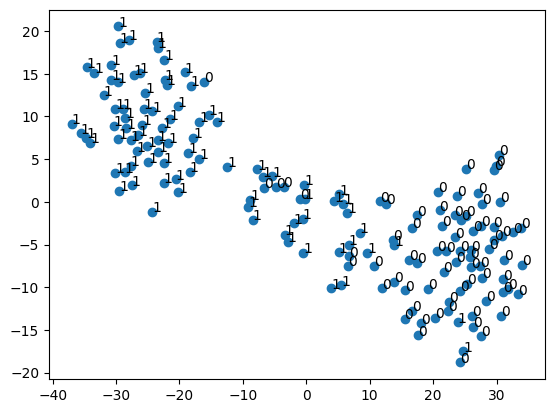

In [59]:
# Adjust the number of batches to match the size of the test dataset
#nbatches = len(loader['test'].dataset) // batch_size
embeddings = get_embeddings(model.encoder.to(device='cpu'), loader['test'], nbatches=10)


Y = TSNE(n_components=2, metric='cosine', init='random', random_state=0, perplexity=10).fit_transform(embeddings)
print(Y.shape)

plt.scatter(Y[:,0], Y[:,1])
for i in range(len(Y)):
    plt.annotate((loader['test'].dataset.labels)[i], xy=(Y[i,0],Y[i,1]))

In [37]:
print((loader["test"].dataset.labels)[10])

1


In [43]:
print(len(loader["test"].dataset.labels))

4849
